In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import os
import random
from tqdm import tqdm
from PIL import Image
import cv2
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.transform import resize
import matplotlib.pyplot as plt
from load_data import load_path, tf_data, tf_classification, get_np_images

print(tf.version.VERSION)

2.3.0


In [2]:
print('Num GPUs Available: ', len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
#Defining parameters

h = 256
w = 256
channels = 3
batch_size = 8
buffer_size = 200
num_epochs = 20
lr = 1e-4
seed = 42
np.random.seed = seed

In [4]:
train_path_hr='Datasets/HYPERTENSION/HR_aug/train'
train_path_nhr='Datasets/HYPERTENSION/HR_aug/train_nonhr'
test_path_hr='Datasets/HYPERTENSION/HR_aug/val'
test_path_nhr='Datasets/HYPERTENSION/HR_aug/val_nonhr'

X_train_hr, X_train_nhr = load_path(train_path_hr, train_path_nhr)
X_test_hr, X_test_nhr = load_path(test_path_hr, test_path_nhr)

Y_train_hr = np.ones(len(X_train_hr))
Y_train_nhr = np.zeros(len(X_train_nhr))
Y_test_hr = np.ones(len(X_test_hr))
Y_test_nhr = np.zeros(len(X_test_nhr))

In [5]:
X_train = X_train_hr + X_train_nhr
Y_train = np.concatenate((Y_train_hr, Y_train_nhr), axis = None)
Y_train = Y_train[:, None]
X_test = X_test_hr + X_test_nhr
Y_test = np.concatenate((Y_test_hr, Y_test_nhr), axis = None)
Y_test = Y_test[:, None]

In [6]:
Train = tf_classification(X_train, Y_train, buffer_size, batch_size, num_epochs)
Test = tf_classification(X_test, Y_test, buffer_size, batch_size, num_epochs)

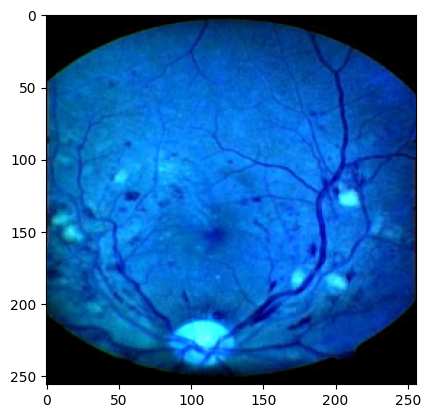

tf.Tensor([1.], shape=(1,), dtype=float32)


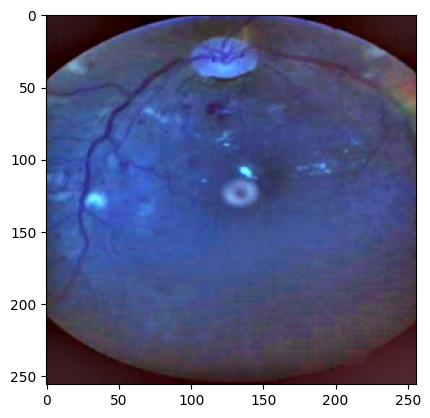

tf.Tensor([1.], shape=(1,), dtype=float32)


In [7]:
for x, y in Train:
    plt.imshow(x[1]);
    plt.show();
    print(y[1])
    break
    
for x, y in Test:
    plt.imshow(x[1]);
    plt.show();
    print(y[1])
    break

In [8]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy, Recall, Precision
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard

In [9]:
from tensorflow.keras.layers import Dense, Dropout, Conv2D, BatchNormalization, Activation, MaxPooling2D, Conv2DTranspose, Concatenate, Input, UpSampling2D, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from keras.applications.xception import Xception

In [10]:
# input_shape = (h, w, 3)
# inputs = Input(shape = (h, w, 3))

# segmented = load_model('densenet121_unet.h5', compile = False)
# for layer in segmented.layers:
#     layer.trainable = False
# x = segmented(inputs)
# x = Conv2D(16, 3, activation = 'relu', padding = 'same')(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
# x = Conv2D(32, 3, activation = 'relu', padding = 'same')(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
# x = Conv2D(64, 3, activation = 'relu', padding = 'same')(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
# x = Conv2D(128, 3, activation = 'relu', padding = 'same')(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
# x = Conv2D(256, 3, activation = 'relu', padding = 'same')(x)
# x = MaxPooling2D(pool_size = (2, 2))(x)
# x = Flatten()(x)
# predictions = Dense(1, activation = 'sigmoid')(x)
# model = Model(inputs = inputs, outputs = predictions)

In [11]:
input_shape = (h, w, 3)
inputs = Input(shape = (h, w, 3))

segmented = load_model('densenet121_unet.h5', compile = False)
for layer in segmented.layers:
    layer.trainable = False
x = segmented(inputs)
x = Conv2D(3, 1, activation = 'linear', padding = "same")(x)

base_model = Xception(weights = 'imagenet', include_top = False, input_shape = (h, w, 3))

x = base_model(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(56, activation = 'relu')(x)
x = Dropout(0.2)(x)
x = Dense(28, activation = 'relu')(x)

predictions = Dense(1, activation = 'sigmoid')(x)
model = Model(inputs = inputs, outputs = predictions)

In [12]:
train_steps = len(X_train)//batch_size
test_steps = len(X_test)//batch_size
if len(X_train) % batch_size != 0:
    train_steps += 1
if len(X_test) % batch_size != 0:
    test_steps += 1

model.compile(optimizer = Adam(lr), loss = 'binary_crossentropy', metrics = ['accuracy', Recall(), Precision()])
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 3)]     0         
_________________________________________________________________
functional_1 (Functional)    (None, 256, 256, 1)       8627809   
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 3)       6         
_________________________________________________________________
xception (Functional)        (None, 8, 8, 2048)        20861480  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)              

In [13]:
model_path = os.path.join('Segmented_HR.h5')
csv_path = os.path.join('Segmented_HR.csv')

callbacks=[
    ModelCheckpoint(model_path, verbose = 1, save_best_only = True),
    tf.keras.callbacks.EarlyStopping(patience = 50, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs'),
    CSVLogger(csv_path),
]

results=model.fit(
    Train,
    validation_data = Test, 
    batch_size = batch_size, 
    steps_per_epoch = train_steps,
    validation_steps = test_steps,
    epochs = 20, 
    callbacks=callbacks)

Epoch 1/20
  1/202 [..............................] - ETA: 0s - loss: 0.6793 - accuracy: 0.6250 - recall: 0.6250 - precision: 1.0000WARNING:tensorflow:From C:\Users\User\.conda\envs\tensorflow\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
202/202 [==============================] - ETA: 0s - loss: 0.5046 - accuracy: 0.8123 - recall: 0.9831 - precision: 0.6410
Epoch 00001: val_loss improved from inf to 0.68102, saving model to Segmented_HR.h5
202/202 [==============================] - 86s 423ms/step - loss: 0.5046 - accuracy: 0.8123 - recall: 0.9831 - precision: 0.6410 - val_loss: 0.6810 - val_accuracy: 0.7043 - val_recall: 0.0000e+00 - val_precision: 0.0000e+00
Epoch 2/20
202/202 [==============================] - ETA: 0s - loss: 0.6586 - accuracy: 0.6822 - recall: 0.0468 - precision: 0.8621
Epoch 00002

202/202 [==============================] - ETA: 0s - loss: 0.0065 - accuracy: 0.9981 - recall: 0.9944 - precision: 1.0000
Epoch 00019: val_loss did not improve from 0.12581
202/202 [==============================] - 78s 384ms/step - loss: 0.0065 - accuracy: 0.9981 - recall: 0.9944 - precision: 1.0000 - val_loss: 0.2790 - val_accuracy: 0.9261 - val_recall: 0.8137 - val_precision: 0.9274
Epoch 20/20
202/202 [==============================] - ETA: 0s - loss: 0.0119 - accuracy: 0.9969 - recall: 0.9944 - precision: 0.9962
Epoch 00020: val_loss did not improve from 0.12581
202/202 [==============================] - 78s 386ms/step - loss: 0.0119 - accuracy: 0.9969 - recall: 0.9944 - precision: 0.9962 - val_loss: 0.2682 - val_accuracy: 0.9043 - val_recall: 0.7304 - val_precision: 0.9312


In [14]:
# from load_data import read_image

# for i in range(len(X_test)):
#     x = read_image(X_test[i])
#     y_pred = model.predict(np.expand_dims(x, axis = 0))
#     print((y_pred>=0.5)==Y_test[i])
print('Train result: ')
results = model.evaluate(Train, batch_size = 128)
print('Test result: ')
results = model.evaluate(Test, batch_size = 128)

Train result: 
4040/4040 [==============================] - 872s 216ms/step - loss: 0.0252 - accuracy: 0.9907 - recall: 0.9719 - precision: 1.0000
Test result: 
1289/1740 [=====================>........] - ETA: 1:43 - loss: 0.2704 - accuracy: 0.9035 - recall: 0.7301 - precision: 0.9319- ETA: 1:43 - loss: 0.2706 - accuracy: 0.9034 - recall: 0.7300 - precision: 0.931

In [15]:
model.save('Segmented_HR.h5')